<a href="https://colab.research.google.com/github/dulatf/nlp_experiments/blob/master/Seq2Seq_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# make sure we have the alpha version of tensorflow 2.0 ready to go in this
# Collab instance
!pip install -q tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.1MB 36kB/s 
     |████████████████████████████████| 61kB 26.3MB/s 
     |████████████████████████████████| 419kB 52.7MB/s 
     |████████████████████████████████| 3.0MB 49.2MB/s 


In [3]:
# manually download the translation data file
!curl -O http://www.manythings.org/anki/deu-eng.zip
!mkdir deu-eng
%cd /content/deu-eng
!unzip ../deu-eng.zip
%cd /content

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4375k  100 4375k    0     0  9532k      0 --:--:-- --:--:-- --:--:-- 9532k
/content/deu-eng
Archive:  ../deu-eng.zip
  inflating: deu.txt                 
  inflating: _about.txt              
/content


In [0]:
import tensorflow as tf # tensorflow of course
tf.debugging.set_log_device_placement(True)
import io # io to read in our file
import re # we use regexp to replace unwated characters in the text
import unicodedata # input text might be unicode, we use this to convert to ascii
from sklearn.model_selection import train_test_split # we use this to split into training and test
import time
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [0]:
# helper function to convert unicode characters to ascii, replaces ü with u etc
def unicode_to_ascii(w):
    return ''.join(c for c in unicodedata.normalize('NFD', w) if unicodedata.category(c) != 'Mn')
# convert the incoming text to ascii, surround punctuation marks with spaces,
# remove multiple spaces and surround sentences with <start> <end> markers
def process_text(text):
    w = unicode_to_ascii(text.lower().strip())
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r'[^a-zA-Z?.!,¿]+', ' ', w)
    w = w.rstrip().strip()
    return '<start> ' + w + ' <end>'
# input and target language sentences are separated by a tab, split and process
def load_dataset(path, num_examples=None):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    if num_examples == None:
        print("Loading {} examples from the dataset.".format(len(lines)))
    return zip(*[[process_text(w) for w in l.split('\t')] for l in lines[:num_examples]])

In [0]:
# we use Keras' preprocessing library to embed the text
# no magic is happening here, this just tokenizes the text by splitting on spaces
# then it creates a dictionary by counting word frequencies
# afterwards the words are mapped to integers (ordered by frequency) that we can
# then use in our model
def tokenize(text):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='post')
    return sequences, tokenizer

# load the dataset and tokenize
def prepare_dataset(path, num_examples=None):
    target_lang, input_lang = load_dataset(path, num_examples)
    input_tensor, input_lang_tokenizer = tokenize(input_lang)
    target_tensor, target_lang_tokenizer = tokenize(target_lang)
    
    return input_tensor, target_tensor, input_lang_tokenizer, target_lang_tokenizer

# helper function to check length of elements in tensor (sentences)
def max_length(tensor):
    return max([len(t) for t in tensor])

In [0]:
input_tensor, target_tensor, input_lang_tokenizer, target_lang_tokenizer = prepare_dataset('/content/deu-eng/deu.txt',10000)

In [8]:
max_length_target, max_length_input = max_length(target_tensor), max_length(input_tensor)
print('Max length input: {}\nMax length target: {}\n'.format(max_length_input, max_length_target))

Max length input: 14
Max length target: 9



In [9]:
# split into training and test set
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)
print('Input train #: {}\nTarget train #: {}\nInput val #: {}\nTarget val #: {}\n'.format(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)))

Input train #: 8000
Target train #: 8000
Input val #: 2000
Target val #: 2000



In [10]:
# look up and print the actual words for a sequence of embedding integers
def wordify(tokenizer, tensor):
    for t in tensor:
        if t != 0:
            print('{} ----> {}\n'.format(t, tokenizer.index_word[t]))
wordify(input_lang_tokenizer, input_tensor_train[0])
wordify(target_lang_tokenizer, target_tensor_train[0])

1 ----> <start>

29 ----> wer

17 ----> hat

166 ----> nichts

22 ----> zu

84 ----> tun

8 ----> ?

2 ----> <end>

1 ----> <start>

30 ----> who

9 ----> s

45 ----> not

69 ----> busy

7 ----> ?

2 ----> <end>



In [11]:
# next we create a tf.Dataset so tensorflow can consume our prepared data
BATCH_SIZE = 16
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(len(input_tensor_train))
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
vocab_input_size = len(input_lang_tokenizer.word_index)+1
vocab_target_size = len(target_lang_tokenizer.word_index)+1
EMBEDDING_DIM = 256
ENCODER_UNITS = 1024
vocab_input_size, vocab_target_size

(3519, 2191)

In [12]:
a, b = next(iter(dataset))
a.shape, b.shape

(TensorShape([16, 14]), TensorShape([16, 9]))

In [0]:
# at this point our dataset is ready to be consumed by our model ... which we have to build next
# first we start with the encoder part,
# this is a set of GRUs that encode the input sequence 

In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.enc_units))

In [0]:
encoder = Encoder(vocab_input_size, EMBEDDING_DIM, ENCODER_UNITS, BATCH_SIZE)
sample_hidden = encoder.initialize_hidden_state()
sample_input_batch, sample_target_batch = next(iter(dataset))
sample_output, sample_hidden = encoder(sample_input_batch, sample_hidden)

In [16]:
sample_input_batch.shape, sample_output.shape

(TensorShape([16, 14]), TensorShape([16, 14, 1024]))

In [0]:
class AttentionModel(tf.keras.Model):
    def __init__(self, units):
        super(AttentionModel,self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
    def call(self, query, values):
        hidden_expanded = tf.expand_dims(query, 1) # turn (a,b) tensor into (a,1,b)
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_expanded)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

In [0]:
attention_layer = AttentionModel(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

In [19]:
attention_result.shape, attention_weights.shape

(TensorShape([16, 1024]), TensorShape([16, 14, 1]))

In [0]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = AttentionModel(self.dec_units)
        
    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        
        output = tf.reshape(output, (-1, output.shape[2]))
        
        x = self.fc(output)
        return x, state, attention_weights

In [0]:
decoder = Decoder(vocab_input_size, EMBEDDING_DIM, ENCODER_UNITS, BATCH_SIZE)

In [0]:
sample_decoder_output, _, _  = decoder(tf.random.uniform((BATCH_SIZE,1)), sample_hidden, sample_output)

In [24]:
sample_decoder_output.shape

TensorShape([16, 3519])

In [25]:
tf.math.logical_not(tf.math.equal(tf.constant([0,1,0]),0))

<tf.Tensor: id=614, shape=(3,), dtype=bool, numpy=array([False,  True, False])>

In [0]:
# now we can define an optimizer and the loss function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')
def loss_func(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    lossy = loss_object(real, pred)
    mask = tf.cast(mask, dtype=lossy.dtype)
    lossy *= mask
    return tf.reduce_mean(lossy)
CHECKPOINT_DIR = './training_checkpoints'
checkpoint_prefix = os.path.join(CHECKPOINT_DIR,'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)


In [0]:
# now we define the training loop
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([target_lang_tokenizer.word_index['<start>']]*BATCH_SIZE,1)
        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input,
                                                 dec_hidden,
                                                 enc_output)
            loss += loss_func(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)
    batch_loss = (loss / int(targ.shape[1]))
    
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients,variables))
    return batch_loss

In [33]:
EPOCHS = 10
for epoch in range(EPOCHS):
    start = time.time()
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch+1,
                                                         batch,
                                                         batch_loss.numpy()))
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
    
    print('Epoch {} Loss {:.4f}'.format(epoch+1, total_loss/steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time()-start))

Epoch 1 Batch 0 Loss 0.0538
Epoch 1 Batch 100 Loss 0.0562
Epoch 1 Batch 200 Loss 0.0498
Epoch 1 Batch 300 Loss 0.0449
Epoch 1 Batch 400 Loss 0.0879
Epoch 1 Loss 0.0737
Time taken for 1 epoch 26.391298055648804 sec

Epoch 2 Batch 0 Loss 0.0558
Epoch 2 Batch 100 Loss 0.0598
Epoch 2 Batch 200 Loss 0.0613
Epoch 2 Batch 300 Loss 0.0442
Epoch 2 Batch 400 Loss 0.0175
Epoch 2 Loss 0.0601
Time taken for 1 epoch 26.60215711593628 sec

Epoch 3 Batch 0 Loss 0.0229
Epoch 3 Batch 100 Loss 0.0354
Epoch 3 Batch 200 Loss 0.0746
Epoch 3 Batch 300 Loss 0.0518
Epoch 3 Batch 400 Loss 0.0284
Epoch 3 Loss 0.0552
Time taken for 1 epoch 26.02177143096924 sec

Epoch 4 Batch 0 Loss 0.0202
Epoch 4 Batch 100 Loss 0.0349
Epoch 4 Batch 200 Loss 0.0112
Epoch 4 Batch 300 Loss 0.1128
Epoch 4 Batch 400 Loss 0.0499
Epoch 4 Loss 0.0521
Time taken for 1 epoch 26.89323115348816 sec

Epoch 5 Batch 0 Loss 0.0300
Epoch 5 Batch 100 Loss 0.0280
Epoch 5 Batch 200 Loss 0.0615
Epoch 5 Batch 300 Loss 0.0288
Epoch 5 Batch 400 Loss 0.

In [0]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_target, max_length_input))
    sentence = process_text(sentence)
    
    inputs = [input_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_input,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''
    
    hidden = [tf.zeros((1, ENCODER_UNITS))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([target_lang_tokenizer.word_index['<start>']], 0)
    for t in range(max_length_target):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)
        attention_weights = tf.reshape(attention_weights, (-1,))
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += target_lang_tokenizer.index_word[predicted_id] + ' '
        if target_lang_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot

In [0]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1,1,1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    plt.show()
    

In [0]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    attention_plot = attention_plot[:len(result.split(' ')),
                                    :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> wir lachen <end>
Predicted translation: we re losing . <end> 


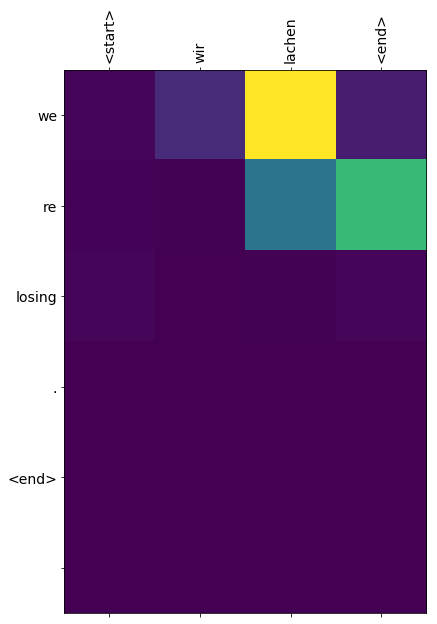

In [32]:
translate(u'wir lachen')